# Assignment 02

## CS345 Fall 2021

### Assigned on October 7, 2021

### Done by \<your name here\>

In this assignment you will be combining several concepts from previous lectures.  Keep in mind this is more about exploring as opposed to implementing any one canonical algorithm.  The data domain will be the 1797 hand written digits already presented in the lectures on nearest neighbor classifers. Briefly, you will be asked to do the following:

- Split the dataset into two almost equal training and test sets. Bring over the nearest neighbor classifier presented in lecture and evaluate how well it solves this problem and how long it takes to run.
- Run the nearest neighbor classifier using only a single example from each class. In one case use the class mean (average image) and in the other the class exemplar (image closest to all others)
- Experiment with PCA as a way to reduce the dimensionality of the digits dataset.  Report how much reduction is possible and how much, if any, the accuracy of digit labeling deteriorates with smaller subspaces.
- Implement a $k$ nearest neighbors algorithm and see how much it does - or does not - improve accuracy on the digits dataset.
- Since the nearest neighbors algorithm generally does well - with few errors - you are to examine more closely these mistakes.  What do the images associated with these mistakes look like?
- Last but not least, get to friends or family members to help you, and record how well people do at properly labeling these problematic images.

A couple of requests. Please, once you have downloaded this notebook, create a copy with your last name added to the file name. This will ultimately be the notebook you turn in for this assignment. Second, keep a clean copy of what you have downloaded. This is important. Note that outputs for code that has been removed is present in what you first download. This represents a huge hint as to what you code should generate. As soon as you "Run All" on the notebook these hints will go away.


## Part 0: Loading Stuff

To get started we need certain libraries and also a dataset.

In [1]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn import datasets
digits = datasets.load_digits()
X = digits.data
y = digits.target

import timeit
import random

## Part 1: Split and Baseline Nearest Neighbor

To get started we will simply divide our dataset in half.  

In [2]:
# Write Code

def create_898_899_split(X, y, rseed=42) :
  X = np.array_split(X, 2)
  y = np.array_split(y, 2)
  return X[1], X[0], y[1], y[0]


In [3]:
# Run Code

X_train, X_test, y_train, y_test = create_898_899_split(X, y)
print(X_train.shape, X_test.shape)

(898, 64) (899, 64)


For this assignment you will use the nearest neighbors class as defined in the ```module02_03_nearest_neighbors.ipynb``` notebook

In [4]:
# Write Code (actually go and get the code)
class nearest_neighbor:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y
    def get_nearest(self, x):
        distances = [distance(x, self.X[i]) 
                     for i in range(len(self.X))]
        return np.argmin(distances)
    def predict(self, x) :
        return self.y[self.get_nearest(x)]


Let us establish both the run-time and the test data accuracy for the nearest neigbhor classifier applied to 50-50  split created. That means specifically that you need to write the code for the function below which creates an instance of a nearest neighbor classifier, sets up the classifier (fits the data) and then applies the classifier to the test data and reports the accuracy.  



In [5]:
# Write Code

def run_nearest_neighbors(X_train, y_train, X_test, y_test) :
  nn = nearest_neighbor()
  nn.fit(X_train, y_train)
  y_pred = np.array([nn.predict(X_test[i]) for i in range(len(X_test))])
  acc = np.sum(y_pred == y_test)/len(y_test)
  print(f'The accuracy is {acc:.3f}') 

def distance(x1, x2):
    return np.linalg.norm(x1-x2)  
  

The following code uses the Jupyter Notebook interface version of the timeit function to compute how long it takes the nearest neighbor algorithm to predict labels for the test image.  Your timeing may vary, running on a MacBook Pro the time was roughly 4 to 5 seconds.

In [6]:
# Run Code

%timeit -r 1 -n 1 run_nearest_neighbors(X_train, y_train, X_test, y_test)


The accuracy is 0.958
1 loop, best of 1: 6.38 s per loop


## Part 2: Class Means and Exemplars

One problem with nearest neighbor classifiers is the computational burden as more training samples are used. To be precise, without some extra work to speed up the search for the nearest neighbor, the algorithm examine every single training sample each and every time the algorithm is asked to predict a label. As a part of this assignment we will examine several possible ways to reduce this burden. To start, what if there were a single sample or synthetic sample that could stand in for the entire class?  We will explore this idea with two distinct ways to construct such a single sample; the average image for the class and the exemplar image for the class. 

### Class Mean

In the cells below you need to write the code to find the mean image for each class, and after that, also the exemplar image for each class. 

In [7]:
# Write Code

def class_means(X_train, y_train) :
    a2D = np.array(  [np.mean(X[y==i], axis = 0) for i in range(y.max() + 1)] )
    return a2D

In [8]:
# Run Code

X_means = class_means(X_train, y_train)
y_means = [i for i in range(10)]

%timeit -r 1 -n 1 run_nearest_neighbors(X_means, y_means, X_test, y_test)

The accuracy is 0.905
1 loop, best of 1: 82.5 ms per loop


Notice the significant drop in run time!   

Also notice the associated drop in accuracy. 

Finally, keep in mind that a random choice algorithm is expected to get the correct answer only 10 percent of the time. In that sense, an accuracy of above 90 percent doing nothing more than comparing to the class means is suggestive of how difficult - or not difficult depending upon one's perpective - this labeling problem is to solve.


### Class Exemplar

As mentioned in lecture, the average image "lies between" many images and matches none perfectly.  Therefore, it is worthwhile to consider if a class exemplar used in place of the mean might improve recognition accuracy.  

Recall from lecture that the exemplar for a class is the image who sum of distances to all other images in the class is less than for any other image in the class. Write the code below to find the exemplars for each class. 

In [9]:
# Write Code

def class_examplars(X_train, y_train) :
  exemps = []
  for i in range(10):
    foo = X_train[y_train==i,:]
    ptdsts = []
    for i in range(len(foo)) :
      alldst = [np.sqrt(np.sum((foo[j]-foo[i])*(foo[j]-foo[i]))) for j in range(len(foo))]
      ptdsts.append(sum(alldst))
    exemps.append(foo[np.argmin(ptdsts)])
  
  # foo = X_train[y_train==0,:]
  # ptdsts = []
  # exemps = []
  # for i in range(len(foo)) :
  #   alldst = [np.sqrt(np.sum((foo[j]-foo[i])*(foo[j]-foo[i]))) for j in range(len(foo))]
  #   ptdsts.append(sum(alldst))
  # exemps.append(foo[np.argmin(ptdsts)])
  # foo = X_train[y_train==1,:]
  # ptdsts = []
  # for i in range(len(foo)) :
  #   alldst = [np.sqrt(np.sum((foo[j]-foo[i])*(foo[j]-foo[i]))) for j in range(len(foo))]
  #   ptdsts.append(sum(alldst))
  # exemps.append(foo[np.argmin(ptdsts)])
  exemplar = np.array(exemps)
  

  return exemplar              

The following code when run will reveal just how much better - or worse - the nearest neighbor algorithm does when using the class exemplars in place of the class means.

In [10]:
# Run Code

X_exemplars = class_examplars(X_train, y_train)
# print(X_exemplars)
# print(X_means)
y_exemplars = [i for i in range(10)]

%timeit -r 1 -n 1 run_nearest_neighbors(X_exemplars, y_exemplars, X_test, y_test)

The accuracy is 0.820
1 loop, best of 1: 154 ms per loop


### Look at Means and Exemplars

It is worthwhile taking a look visually at the difference between the class averages and the exemplars. What can you see as noticable differences?


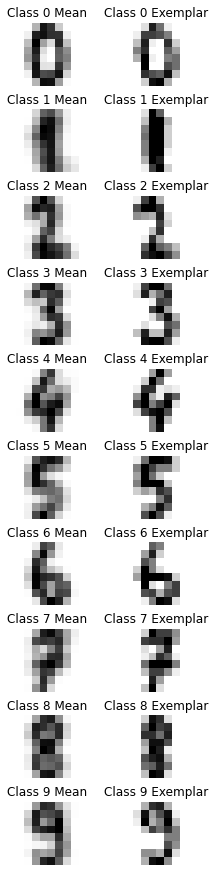

In [11]:
# Run Code

def plot_means_and_exemplars(X_means, X_exemplars) :
    axes = plt.figure(figsize=[3,12], constrained_layout=True).subplots(10,2)
    for ax, ci in zip(axes, [i for i in range(10)]) :
        ax[0].set_title('Class %i Mean' % ci)
        ax[1].set_title('Class %i Exemplar' % ci)
        ax[0].set_axis_off()
        ax[0].imshow(np.resize(X_means[ci], (8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
        ax[1].set_axis_off()
        ax[1].imshow(np.resize(X_exemplars[ci], (8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

plot_means_and_exemplars(X_means, X_exemplars)     

### Puzzle: Pick Which is Which

Based upon what you see above here is a puzzle to solve.  The following function is given a class exemplar and a class mean for the same class. However, they may be given in either order.  What your function must do is determint which is which.  To solve this here are some strong hints.  Think for a moment about how averaging many images together may change pixel values.  You might want to look carefully at histograms of the pixel values in pairs of mean and exemplar images for a given class.  Hopefully going down that path of investigation will show you that what you are being asked to accomplish here involes a bit of coding - but it is NOT excessively complex. Further, you are being asked to write code that implements a simple rule. If are are starting to think you need to use machine learning in general to solve this problem you have started down a needlessly complex path.

In [12]:
# Write Code

def means_exemplars_choose(A, B) :
  sum = 0
  for i in range(len(A)):
    sum += np.floor(A[i]) - A[i]
  # print(sum)
  '''The digit images must be from a single class and the 
       function reports, prints, which is the exemplar and which the mean. '''
  # print(np.floor(A[3]) - A[3])
  if sum == 0.0:
    print("From my rule: 	B is the mean image and A is the exemplar image")
  else:
    print("From my rule: 	A is the mean image and B is the exemplar image")
  # print(sum)
    # print(A[3])
    # print(B[3])
    # print()
 

As you can readily see, if you discovered a reliable rule and implemented that rule in the above function, then the code below will generate one test case per class and you can immediately see if your rule gets the correct answer. 

In [13]:
# Run Code

for i in range(10) :
    print(f'Class {i}')
    if (np.random.uniform(0.0, 1.0) < 0.5) :
        A = X_means[i]
        B = X_exemplars[i]
        print(f'Ground Truth: \tA is the mean image and B is the exemplar image')
        means_exemplars_choose(A, B)
    else :
        B = X_means[i]
        A = X_exemplars[i]
        print(f'Ground Truth: \tB is the mean image and A is the exemplar image')
        means_exemplars_choose(A, B)        

Class 0
Ground Truth: 	A is the mean image and B is the exemplar image
From my rule: 	A is the mean image and B is the exemplar image
Class 1
Ground Truth: 	B is the mean image and A is the exemplar image
From my rule: 	B is the mean image and A is the exemplar image
Class 2
Ground Truth: 	A is the mean image and B is the exemplar image
From my rule: 	A is the mean image and B is the exemplar image
Class 3
Ground Truth: 	B is the mean image and A is the exemplar image
From my rule: 	B is the mean image and A is the exemplar image
Class 4
Ground Truth: 	B is the mean image and A is the exemplar image
From my rule: 	B is the mean image and A is the exemplar image
Class 5
Ground Truth: 	A is the mean image and B is the exemplar image
From my rule: 	A is the mean image and B is the exemplar image
Class 6
Ground Truth: 	B is the mean image and A is the exemplar image
From my rule: 	B is the mean image and A is the exemplar image
Class 7
Ground Truth: 	B is the mean image and A is the exempl

## Part 3: Use Fewer Features - PCA

In Assignment 1 you became familiar with creating a new feature which was a linear combination of the original features. In this hand written digit recognition problem we have $64$ features per image, i.e. each pixel represents a feature.  As you look at the image you already likely suspect not all pixels are equally useful for predicting the digit label.

What if we could find one or two linear combinations of pixels that together made predicting the labels relatively easy?  

No surprise the answer is we can do exactly as proposed by this question, and one of the most common ways to find these combinations is using [Principal Components Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA).  This has been covered in lecture, but for the sake of clarity, here is a bit of the mathematical setup. 

Let us be clear here, when we say a linear combination what we mean is a weighted sum of the individual pixel values in and image. Going a bit more into detail, let $w$ be a vector of weights (the length of $w$ is $64$).  Then for an image $x$ (again a vector of length $64$) a new feature $f_1$ is just the weighted sum of pixel values:

$$
   f_1 = w^T  x
$$

Now you may start to see one of the underlying reasons that Assignment 1 emphasized projecting a data sample onto a basis vector - the equation above is exactly the same used in Assignment 1 with the caveat that now our original sample $x$ has $64$ elements and therefore $w$ contains $64$ numbers - the weight for each pixel dimension.  Finally, note again that for convenience it is best to normalize $w$ to be of unit length ($w^T w \: = \: 1$)

### Find the Principal Components

You already have an exmaple of code to find the principal components given a set of data samples $X$. Use that knowledge here to applie PCA to the training set of digit images.

In [14]:
# Write Code

from sklearn.decomposition import PCA

def find_subspace (X_train, X_test, subspace_dims) :
  subspace_size = subspace_dims
  pca = PCA(n_components=subspace_size)
  pca.fit(X_test)
  X_train_pca = pca.transform(X_train)
  pca.fit(X_test)
  X_test_pca = pca.transform(X_test)
  return X_train_pca, X_test_pca, pca
   

### Explore Only 2 Features

To take this new ability out for a spin, consider the extreme case posed as a question above.  What about using only the first two principal components.

In [15]:
# Run Code

Xs_train, Xs_test, Pvs = find_subspace(X_train, X_test, 2)

%timeit -r 1 -n 1 run_nearest_neighbors(Xs_train, y_train, Xs_test, y_test)

The accuracy is 0.524
1 loop, best of 1: 6.08 s per loop


As already pointed out in lecture, a two dimensional features space lends itself well to visual inspection.  Run the following code and you should see laid out before the the relative distribution of image as projected onto the first and second principal components.  

Please note that while mastering matplotlib is important, creating visually satisfying graphics is a time consuming, intricate, and even at times tedious process. Therefore, please take the time to look carfully at the code below - and perhaps issue a sigh of relief that in this case you were not asked to create it from scratch so as to match the resulting pair of stacked plots. 

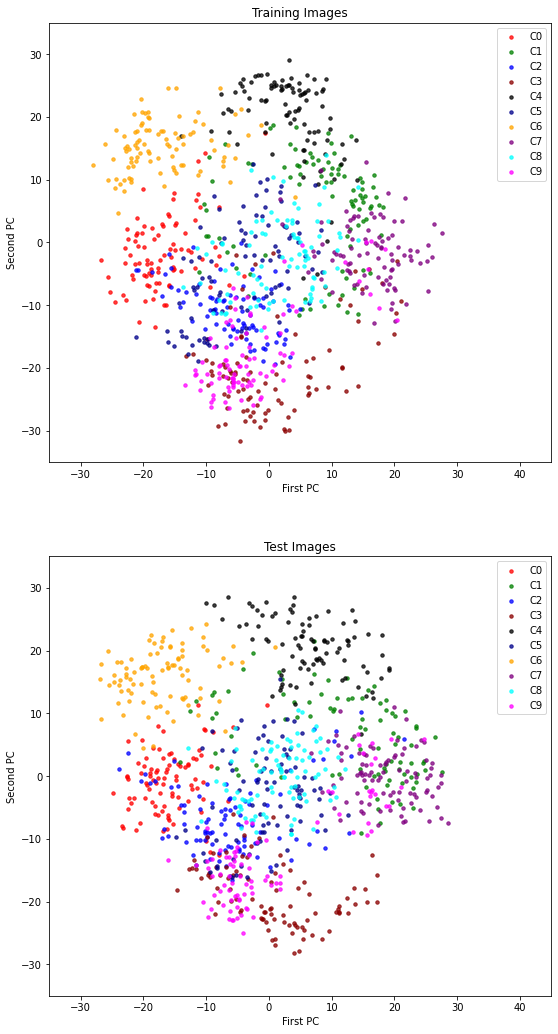

In [16]:
# Run Code

def plot_train_test_in_subspaces(Xs_train, y_train, Xs_test, y_test) :
    my_colors = ['red', 'green', 'blue', 'darkred', 'black', 'darkblue','orange','purple','cyan','magenta']
    dig_labels = ['C' + str(i) for i in range(10)]   
    fig, axes = plt.subplots(2, 1)
    fig.set_size_inches(9, 18)
    ax = axes[0]; ax.set_aspect('equal')
    for ci in range(10) :
        Xs = Xs_train[y_train == ci]
        ax.set_xlim((-35,45)); ax.set_ylim((-35,35))
        ax.scatter(Xs[:,0], Xs[:,1], c=my_colors[ci], s=12, label=dig_labels[ci], alpha=0.75)
        ax.set_xlabel('First PC'); ax.set_ylabel('Second PC')
        ax.set_title('Training Images'); ax.legend()
    ax = axes[1]; ax.set_aspect('equal')
    for ci in range(10) :
        Xs = Xs_test[y_test == ci]
        ax.set_xlim((-35,45)); ax.set_ylim((-35,35))
        ax.scatter(Xs[:,0], Xs[:,1], c=my_colors[ci],s= 12, label=dig_labels[ci], alpha=0.75)
        ax.set_xlabel('First PC'); ax.set_ylabel('Second PC')
        ax.set_title('Test Images'); ax.legend()
    pass

plot_train_test_in_subspaces(Xs_train, y_train, Xs_test, y_test)

### What about 9 Features

You can equally well ask what about going from a $64$ dimensional problem to a $9$ dimensional problem.  

How well does a nearest neighbor algorithm perform in this case?

In [17]:
# Run Code

Xs_train, Xs_test, Pvs = find_subspace(X_train, X_test, 9)

%timeit -r 1 -n 1 run_nearest_neighbors(Xs_train, y_train, Xs_test, y_test)

The accuracy is 0.921
1 loop, best of 1: 6.06 s per loop


In [18]:
# Write Code

def generate_accuracy_for_sizes(X_train, y_train, X_test, y_test, dims_min = 2, dims_max = 16) :
  results = np.ones((14,2))
  for i in range(dims_max-dims_min):
    Xs_train, Xs_test, Pvs = find_subspace(X_train, X_test, i + 2)
    # run_nearest_neighbors(Xs_train, y_train, Xs_test, y_test)
    nn = nearest_neighbor()
    nn.fit(Xs_train, y_train)
    y_pred = np.array([nn.predict(Xs_test[i]) for i in range(len(Xs_test))])
    acc = np.sum(y_pred == y_test)/len(y_test)
    print(f'The accuracy is {acc:.3f}') 
    results[i][0] = i + 2
    results[i][1] = acc
  return results
  

Now run the following code to plot the accuracy versus subspace size.

Keep in mind this may take a bit of time to accomplish so feel free to comment out the function call when testing other portions of this notebook.

The accuracy is 0.524
The accuracy is 0.666
The accuracy is 0.786
The accuracy is 0.835
The accuracy is 0.859
The accuracy is 0.873
The accuracy is 0.891
The accuracy is 0.921
The accuracy is 0.918
The accuracy is 0.924
The accuracy is 0.932
The accuracy is 0.944
The accuracy is 0.942
The accuracy is 0.945


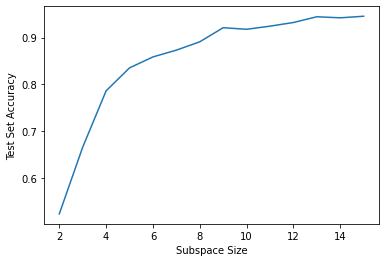

In [19]:
# Run Code

def plot_subspace_size_vs_accuracy (X_train, y_train, X_test, y_test) :
    accs = generate_accuracy_for_sizes(X_train, y_train, X_test, y_test)
    plt.plot(accs[:,0], accs[:,1])
    plt.xlabel('Subspace Size')
    plt.ylabel('Test Set Accuracy')
    pass

plot_subspace_size_vs_accuracy (X_train, y_train, X_test, y_test) 

## Part 4: K Nearest Neighbors

So far it appears the nearest neighbors algorithm on the digits data set is performing very well with test set accuracy exceeding $98$ percent.  One way to attempt to squeeze a bit more performance out of the algorithm is to use the $k$ nearest neighbors extension of the original nearest neighbors algorithm. In other word, find the $k$ nearest neighbors to an unlabeled sample and then let these labled samples vote for the most likely label. 

Here please implement a new class of labeling algorithms which is a $k$ nearest neighbor algorithm rather than the previous which amounts to a $k=1$ algorithm

In [35]:
# Write Code
from sklearn.neighbors import KNeighborsClassifier
class k_nearest_neighbor:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y
    def get_nearest(self, x):
        distances = [distance(x, self.X[i]) for i in range(len(self.X))]
        print(np.argmin(distances))
        return np.argmin(distances)
    def predict(self, x, k) :
        return self.y[self.get_nearest(x)]
   
   

In [36]:
# Run Code

def run_k_nearest_neighbors(k, X_train, y_train, X_test, y_test) :
    knn = k_nearest_neighbor()
    knn.fit(X_train, y_train)
    y_pred = np.array([knn.predict(X_test[i],k) for i in range(len(X_test))])
    acc = np.sum(y_pred == y_test)/len(y_test)
    # print(f'The accuracy is {acc:.3f}')
    return acc

Now let us use the $k$ nearest neighbor algorithm and are nearly 50-50 training test split to look at how accuracy changes as a function of $k$ in the range of $1$ to $7$.

In [ ]:
# Run Code

for i in range(1,8) :
    acc = run_k_nearest_neighbors(i, X_train, y_train, X_test, y_test)
    print(f'For k equals {i} the accuracy is {acc:.4f}')

Note that the role of training and test can be reversed, so repeated the above switching the training for the test and vice-versa

In [ ]:
# Run Code

for i in range(1,8) :
    acc = run_k_nearest_neighbors(i,X_test, y_test, X_train, y_train )
    print(f'For k equals {i} the accuracy is {acc:.4f}')

## Part 5: Mistakes Were Made

It should be standing out to you now that it seems that even when trying several different tricks to either improve speed and/or improve accuracy there remains a ceiling on the level of performance for the digit dataset.

Why might that be?

Moreover, this is not unusual for a machine learning problem.  At this point working with a dataset it is time to stop treating accuracy as a black box and start pocking around in an effort to make sense of the mistakes being made by the labeling algorithm. 


### Return Failed Matches (tests)

The approach you are to follow here is to extend the functionality of the nearest neighbor classifier with a single new method ```mistakes```.

This method is to be run after the data is fit to the model - which for this algorithm means after the traning samples and labels are store (memorized). The method takes an entire test set of images and corresponding labels.

The ```mistakes``` method returns a list of dictionaries. To be more precise, it returns a list of individual mistakes wehre a mistake is itself a dictionary with four named elements. These are in order: 

- ```test``` a test image mislabeled
- ```match``` the training image closest to the test image
- ```true``` the true label of the test image
- ```pred``` the predicted label of the test image

In [ ]:
# Write Code

class nearest_neighbor_extended:
    def __init__(self):
        pass


In [ ]:
# Run Code

nne = nearest_neighbor_extended()
nne.fit(X_train, y_train)
failed_matches = nne.mistakes(X_test, y_test)

In [ ]:
# Run Code

def plot_false_matches(fms) :
    num_fm    = len(fms)
    num_plots = num_fm * 2
    pairs_per_line = 3
    cols = 2 * pairs_per_line
    rowis = [i // cols for i in range(num_plots)]
    colis = [i % cols for i in range(num_plots)]
    rows = max(rowis) + 1
    fig, axes = plt.subplots(rows, cols)
    fig.set_size_inches(8, 11)
    for i in range(num_plots) :
        fm = fms[i // 2]
        ax = axes[rowis[i]][colis[i]]
        ax.set_axis_off()
        if (i % 2 == 0) :
            img = np.resize(fm['test'], (8,8))
            ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
            ax.set_title('True: %i' % fm['true'])
        else :
            img = np.resize(fm['match'], (8,8))
            ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
            ax.set_title('Match: %i' % fm['pred'])
    pass

In [ ]:
# Run Code

plot_false_matches(failed_matches)

## Part 6: What do People Think?

Now that you have a list of dictionaries summarizing the mistakes made by the nearest neighbor classifier it is worth taking a moment to ask how well people do classifying these images.  

Indeed, you must to complete this section do two things. First, generate pdf images of the images that participated in the false matches shown above.  Two, present printed versions of these to at least two friends and have them in pen have them write the label they think best fits each images.  Yes, they may be doing a lot if intelligent guessing.

In [ ]:
# Write Code

def shuffle_failed_matches (fms, rseed) :


The ```shuffle_failed_matches``` will create an array of dictionaries.  Each dictionary element is a pair.  The first is named ```im``` and the associated value is an image. The image is either a test image or a nearest neighbor match to a test image from the ```failed_matches``` created above. When you have implemented ```shuffle_failed_matches``` correctly you should get output matching the following when you run the next code cell.

In [ ]:
# Run Code

images_to_review = shuffle_failed_matches(failed_matches, 42)
for img_label in images_to_review :
    x = img_label['im']
    l = img_label['label']
    print(f'Image {x[0:8]} ... Label {l}')

As was done above, the following is a relatively complex plotting function and it is being given to you.

In [ ]:
# Run Code 

def plot_permuted_failed_match_images(fms, rseed, show_labels=True, file_name='') :
    num_plots = len(fms)
    pairs_per_line = 3
    cols = 2 * pairs_per_line
    rowis = [i // cols for i in range(num_plots)]
    colis = [i % cols for i in range(num_plots)]
    rows = max(rowis) + 1
    fig, axes = plt.subplots(rows, cols)
    fig.set_size_inches(8, 11)
    fig.suptitle('Images in randomized order with seed %i' % rseed)
    for i in range(num_plots) :
        fm = fms[i]
        ax = axes[rowis[i]][colis[i]]
        ax.set_axis_off()
        img = np.resize(fm['im'], (8,8))
        ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
        if show_labels : 
            ax.set_title('Label: %i' % fm['label'])
    if (file_name != '') :
        plt.savefig(file_name)
    pass

### How do people perform?

You last task is to take the code below, change the random seed, and run the code.  It will generate two PDF files. Print out one copy of the figure with labels.  Print out 2 copies without labels and give one each to a different friend or family member and have them write in pen what digit they think each represents.  

In [ ]:
# Pick a seed that is not 42 and unlikely to be used by other students
rseed = 42

# Run Code
images_to_review = shuffle_failed_matches(failed_matches, rseed)
plot_permuted_failed_match_images(images_to_review, rseed, show_labels=True, 
                                  file_name='hard_digits_labeled.pdf')
plot_permuted_failed_match_images(images_to_review, rseed, show_labels=False, 
                                  file_name='hard_digits_no_labels.pdf')

### Wrap Up 

Now please add to this markdown cell the results for you two person experiment.  Namely, how many did the first person label correctly? How many did the second person label correctly?  Comment briefly about what you think this tells us about expecting perfect performance on the digits dataset. 